<a href="https://colab.research.google.com/github/GermanOmar/data_LPBF/blob/master/relative_density_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset preprocessing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'  # Cambia a la fuente deseada
plt.rcParams['font.size'] = 12
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Reading Training Data
file_name = '/content/drive/MyDrive/GOOGLE COLAB/Paper_Relative_Density/dataset.xlsx'
sheet_name = 'data'
start_row = 1
end_row = 1580
use_columns = 'A:L'
training_df = pd.read_excel(file_name,
                            sheet_name=sheet_name,
                            usecols=use_columns,
                            nrows=(end_row - start_row))
training_df.tail()

,Material,Density Measurement Method,Atmosphere,Printed Geom.,Laser Power (W),Scan Speed (mm/s),Hatch space (mm),Layer thickness (mm),Spot size (mm),Geometric Factor,D50 μm,RD (%)
1574,18Ni300,Archimedes method,NI,Prismatic,250.0,900.0,0.1,0.03,0.065,24.99913,27.57,99.65432
1575,18Ni300,Archimedes method,NI,Prismatic,250.0,1000.0,0.1,0.03,0.065,24.99913,27.57,98.83951
1576,18Ni300,Archimedes method,NI,Prismatic,250.0,1100.0,0.1,0.03,0.065,24.99913,27.57,98.08642
1577,18Ni300,Archimedes method,NI,Prismatic,250.0,1200.0,0.1,0.03,0.065,24.99913,27.57,98.46914
1578,18Ni300,Archimedes method,NI,Prismatic,250.0,1300.0,0.1,0.03,0.065,24.99913,27.57,98.96296


In [ ]:
mappings = {'Material': {'316L': 1, 'IN718': 2, 'Ti6Al4V': 3, 'CuCrZr': 4, 'AlSi10Mg': 5, '18Ni300': 6},
            'Atmosphere': {'Argon': 1, 'Nitrogen': 2, 'NI': 3},
            'Density Measurement Method': {'Archimedes method': 1, 'Image analysis': 2, 'Other': 3},
            'Printed Geom.': {'Prismatic': 1, 'Cylindrical': 2, 'Tensile Samples': 3, 'Other': 4, 'NI': 5}
           }
df = training_df.copy()
for column, mapping in mappings.items():
    df[column] = df[column].map(mapping)
df.head()

,Material,Density Measurement Method,Atmosphere,Printed Geom.,Laser Power (W),Scan Speed (mm/s),Hatch space (mm),Layer thickness (mm),Spot size (mm),Geometric Factor,D50 μm,RD (%)
0,1,2,1,1,100.0,250.0,0.114,0.05,0.2,15.9232,40.8,95.40
1,1,2,1,1,100.0,250.0,0.114,0.05,0.2,15.9232,40.8,97.70
2,1,2,1,1,100.0,250.0,0.114,0.05,0.2,15.9232,40.8,93.80
3,1,2,1,1,100.0,175.0,0.114,0.05,0.2,15.9232,40.8,93.90
4,1,2,1,1,100.0,120.0,0.111,0.05,0.2,15.9232,40.8,97.14


In [ ]:
print(df.isna().any())

Material                      False
Density Measurement Method    False
Atmosphere                    False
Printed Geom.                 False
Laser Power (W)               False
Scan Speed (mm/s)             False
Hatch space (mm)              False
Layer thickness (mm)          False
Spot size (mm)                False
Geometric Factor              False
D50 μm                        False
RD (%)                        False
dtype: bool


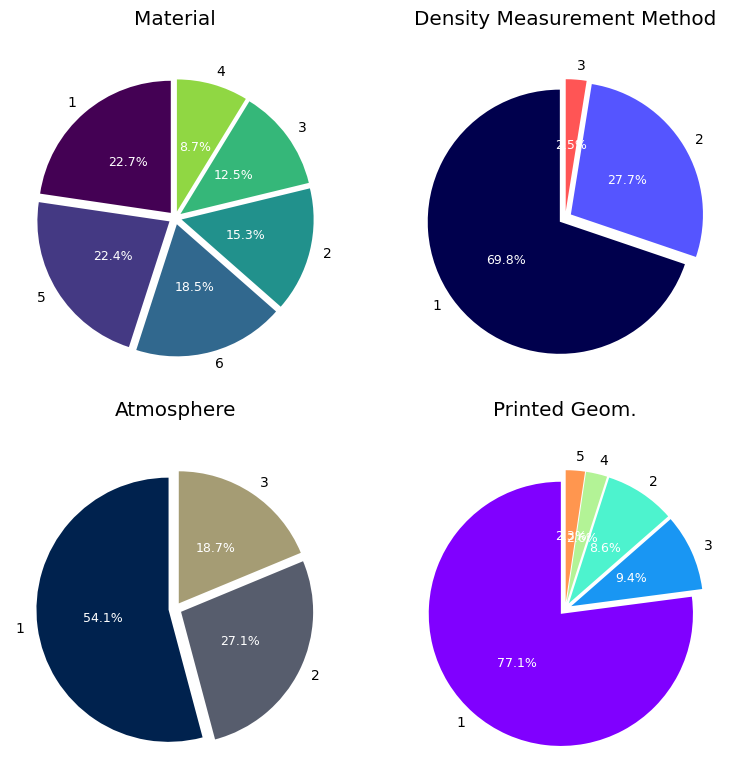

In [ ]:
columns_to_plot = ['Material', 'Density Measurement Method', 'Atmosphere', 'Printed Geom.']
colormaps = ['viridis', 'seismic', 'cividis', 'rainbow']

def plot_pie_chart(ax, data, column_name, colormap_name):
    data_counts = data[column_name].value_counts()
    colormap = plt.colormaps[colormap_name]
    colors = [colormap(j / len(data_counts)) for j in range(len(data_counts))]
    explode = [0.05] * len(data_counts)
    wedges, texts, autotexts = ax.pie(
        data_counts, labels=data_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors, explode=explode, pctdistance=0.5
    )

    for text in texts:
        text.set_fontsize(10)
    for text in autotexts:
        text.set_color('white')
        text.set_fontsize(9)

    ax.set_title(f'{column_name}', pad=20)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for i, column in enumerate(columns_to_plot):
    ax = axs[i//2, i%2]
    plot_pie_chart(ax, df, column, colormaps[i])

plt.tight_layout()
plt.show()

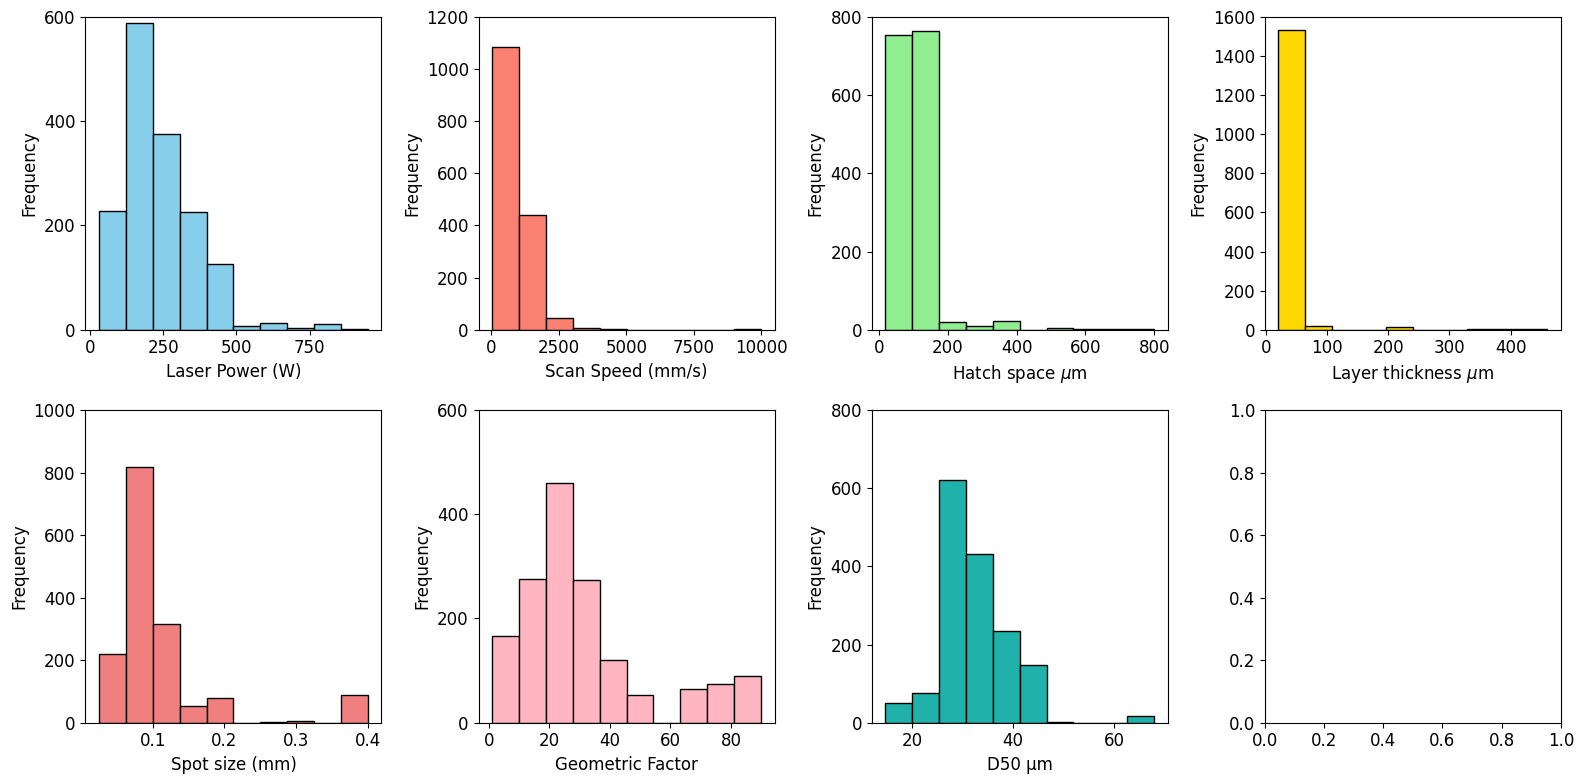

In [ ]:
numeric_columns = ['Laser Power (W)', 'Scan Speed (mm/s)', 'Hatch space (mm)',
                   'Layer thickness (mm)', 'Spot size (mm)', 'Geometric Factor', 'D50 μm']
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'lightpink', 'lightseagreen']
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i, column in enumerate(numeric_columns):
    frequencies, bin_edges = np.histogram(df[column], bins=10)
    max_frequency = frequencies.max()
    ax = axs[i//4, i%4]
    if (i==2):
      ax.hist(df[column]*1000, bins=10, color=colors[i], edgecolor='black')
      ax.set_xlabel('Hatch space $\mu$m')
    elif (i==3):
      ax.hist(df[column]*1000, bins=10, color=colors[i], edgecolor='black')
      ax.set_xlabel('Layer thickness $\mu$m')
    else:
      ax.hist(df[column], bins=10, color=colors[i], edgecolor='black')
      ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    #ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim([0, max_frequency])
    ax.set_yticks(np.arange(0, max_frequency+200, 200))

plt.tight_layout()
plt.show()

In [ ]:
# Mutual Information
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, :-1]
y = df.iloc[:, -1].values.reshape(-1,1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_zscored = scaler.fit_transform(y)
y = y_zscored.flatten()
X = X_scaled
mi = mutual_info_regression(X, y)

mi_df = pd.DataFrame({
    'Feature': training_df.columns[:-1],
    'Mutual Information': mi
})

mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

                       Feature  Mutual Information
10                      D50 μm            0.561163
9             Geometric Factor            0.514258
4              Laser Power (W)            0.361781
8               Spot size (mm)            0.301497
5            Scan Speed (mm/s)            0.273969
6             Hatch space (mm)            0.272832
0                     Material            0.174667
7         Layer thickness (mm)            0.147197
1   Density Measurement Method            0.106868
3                Printed Geom.            0.088011
2                   Atmosphere            0.076338


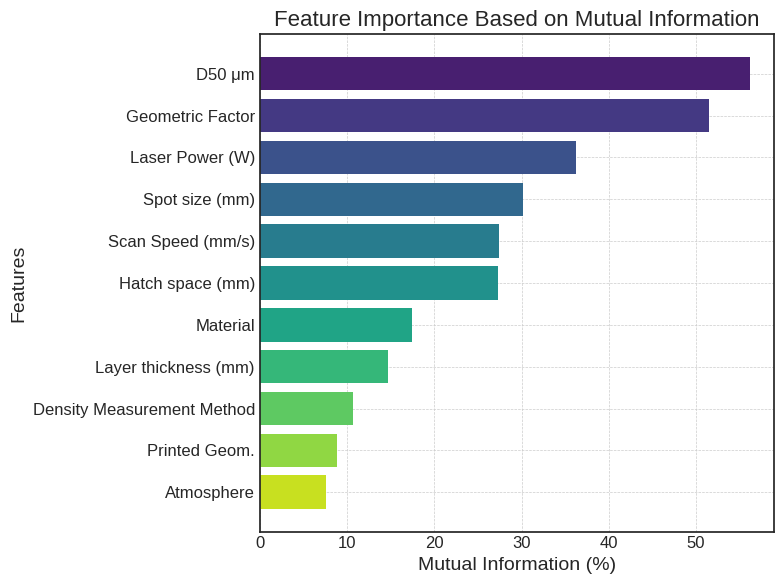

In [ ]:
# Plotting
plt.style.use('seaborn-v0_8-white')
palette = sns.color_palette("viridis", len(mi_df))
plt.figure(figsize=(8, 6))
plt.barh(mi_df['Feature'], mi_df['Mutual Information']*100, color=palette)
plt.xlabel('Mutual Information (%)', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importance Based on Mutual Information', fontsize=16)
plt.gca().invert_yaxis()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

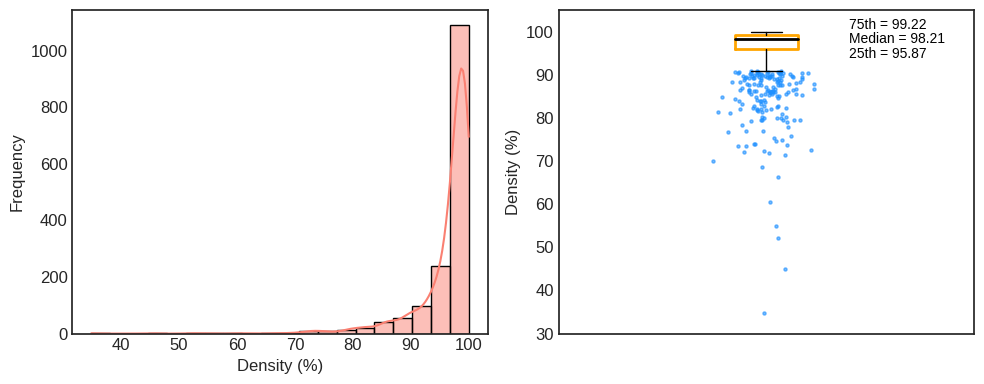

In [ ]:
rd_data = df['RD (%)']
median = np.median(rd_data)
percentile_25 = np.percentile(rd_data, 25)
percentile_75 = np.percentile(rd_data, 75)
IQR = percentile_75 - percentile_25
lower_bound = percentile_25 - 1.5 * IQR
upper_bound = percentile_75 + 1.5 * IQR
# Identify outliers
outliers = rd_data[(rd_data < lower_bound) | (rd_data > upper_bound)]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Subplot 1:
sns.histplot(rd_data, bins=20, kde=True, color='salmon', edgecolor='black', ax=axs[0])
axs[0].set_xlabel('Density (%)')
axs[0].set_ylabel('Frequency')

# Subplot 2: Boxplot
boxprops = dict(color='orange', linewidth=2)
medianprops = dict(color='black', linewidth=2)
axs[1].boxplot(rd_data, vert=True, patch_artist=False, boxprops=boxprops, medianprops=medianprops, showfliers=False)


y = outliers
x = np.random.normal(1, 0.04, size=len(y))
axs[1].scatter(x, y, alpha=0.6, color='dodgerblue', s=5)


axs[1].text(1.2, median, f'Median = {median:.2f}', verticalalignment='center', fontsize=10, color='black')
axs[1].text(1.2, percentile_25-1, f'25th = {percentile_25:.2f}', verticalalignment='center', fontsize=10, color='black')
axs[1].text(1.2, percentile_75+2.34, f'75th = {percentile_75:.2f}', verticalalignment='center', fontsize=10, color='black')


axs[1].set_ylabel('Density (%)')
axs[1].set_xticks([])
axs[1].set_ylim(30, 105)
axs[1].set_yticks(np.arange(30, 105, 10))


plt.tight_layout()
plt.show()

# Training

In [ ]:
#---------Scikit-learn Utilities---------------------------------------------------------------------------------------------
from sklearn.metrics import r2_score as R2
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel,ConstantKernel as C
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
#----------------------------------------------------------------------------------------------------------------------------
import joblib
import pickle
import xgboost as xgb
import os

In [ ]:
output_folder = '/content/drive/MyDrive/GOOGLE COLAB/Paper_Relative_Density/GitHub/trained_models/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def loading_cluster(sheet_name):
    df = pd.read_excel(file_name, sheet_name=sheet_name)
    return df

param_grid = {
    "XGBRegressor": {
        'learning_rate': [0.001, 0.01],
        'max_depth': [2, 3, 4, 5],
        'n_estimators': [100, 200, 300, 400],
      },
    "RandomForestRegressor": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [2, 4, 6],
        'bootstrap': [True, False]
        }
    }

results = pd.DataFrame(columns=["File", "Model", "R2_train", "MSE_train",
                                "MAE_train", "R2_test", "MSE_test", "MAE_test"])
for i in range(1, 5):
  sheet_name = f'Cluster {i}'
  df = loading_cluster(sheet_name)
  print('-'*50)
  print(f'Processing Cluster {i}...')
  print('-'*50)
  X = df.iloc[:, :-1]
  y = df.iloc[:, -1]
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

  kf = KFold(n_splits=5, shuffle=True, random_state=42)

  for model_name, model in param_grid.items():
    print(f'Optimizing {model_name}...')

    if model_name == "XGBRegressor":
      estimator = xgb.XGBRegressor()
    elif model_name == "RandomForestRegressor":
      estimator = RandomForestRegressor()



    grid_search = GridSearchCV(estimator=estimator, param_grid=model, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_scaled, y)
    best_model = grid_search.best_estimator_
    print(f"Best hyperparameters for {model_name}: {grid_search.best_params_}")

    best_model.fit(X_train, y_train)
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    MSE_train = MSE(y_train, y_train_pred)
    MSE_test = MSE(y_test, y_test_pred)
    r2_train = R2(y_train, y_train_pred)
    r2_test = R2(y_test, y_test_pred)
    mae_train = MAE(y_train, y_train_pred)
    mae_test = MAE(y_test, y_test_pred)
    print('-'*100)
    print(f'Error Metrics')
    print(f'Training: MAE={mae_train:.4f}, MSE={MSE_train:.4f}, R2={r2_train:.4f}')
    print(f'Testing: MAE={mae_test:.4f}, MSE={MSE_test:.4f}, R2={r2_test:.4f}')
    print('-'*100)
    model_filename = f'{output_folder}{model_name}_best_model_cluster_{i}.pkl'
    joblib.dump(best_model, model_filename)

--------------------------------------------------
Processing Cluster 1...
--------------------------------------------------
Optimizing XGBRegressor...
Best hyperparameters for XGBRegressor: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400}
----------------------------------------------------------------------------------------------------
Error Metrics
Training: MAE=0.6045, MSE=0.9764, R2=0.9134
Testing: MAE=1.0558, MSE=5.4385, R2=0.8061
----------------------------------------------------------------------------------------------------
Optimizing RandomForestRegressor...


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters for RandomForestRegressor: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
----------------------------------------------------------------------------------------------------
Error Metrics
Training: MAE=0.3794, MSE=0.5241, R2=0.9535
Testing: MAE=1.1623, MSE=4.9090, R2=0.8249
----------------------------------------------------------------------------------------------------
--------------------------------------------------
Processing Cluster 2...
--------------------------------------------------
Optimizing XGBRegressor...
Best hyperparameters for XGBRegressor: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400}
----------------------------------------------------------------------------------------------------
Error Metrics
Training: MAE=0.8061, MSE=1.7646, R2=0.9220
Testing: MAE=1.6324, MSE=6.7117, R2=0.6957
----------------------------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters for RandomForestRegressor: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
----------------------------------------------------------------------------------------------------
Error Metrics
Training: MAE=1.3659, MSE=12.7782, R2=0.8093
Testing: MAE=1.3495, MSE=5.4098, R2=0.6251
----------------------------------------------------------------------------------------------------
--------------------------------------------------
Processing Cluster 4...
--------------------------------------------------
Optimizing XGBRegressor...
Best hyperparameters for XGBRegressor: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400}
----------------------------------------------------------------------------------------------------
Error Metrics
Training: MAE=1.0168, MSE=2.4741, R2=0.9198
Testing: MAE=1.7680, MSE=7.5444, R2=0.8180
----------------------------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters for RandomForestRegressor: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
----------------------------------------------------------------------------------------------------
Error Metrics
Training: MAE=1.0160, MSE=3.0642, R2=0.9007
Testing: MAE=1.7385, MSE=6.7308, R2=0.8377
----------------------------------------------------------------------------------------------------


# Predictions

Cluster 1 Metrics:
Training: MAE=0.6045, MSE=0.9764, R2=0.9134
Testing: MAE=1.0558, MSE=5.4385, R2=0.8061
--------------------------------------------
Cluster 2 Metrics:
Training: MAE=0.8061, MSE=1.7646, R2=0.9220
Testing: MAE=1.6324, MSE=6.7117, R2=0.6957
--------------------------------------------
Cluster 3 Metrics:
Training: MAE=1.2749, MSE=5.6986, R2=0.9150
Testing: MAE=1.3666, MSE=3.8156, R2=0.7356
--------------------------------------------
Cluster 4 Metrics:
Training: MAE=1.0168, MSE=2.4741, R2=0.9198
Testing: MAE=1.7680, MSE=7.5444, R2=0.8180
--------------------------------------------


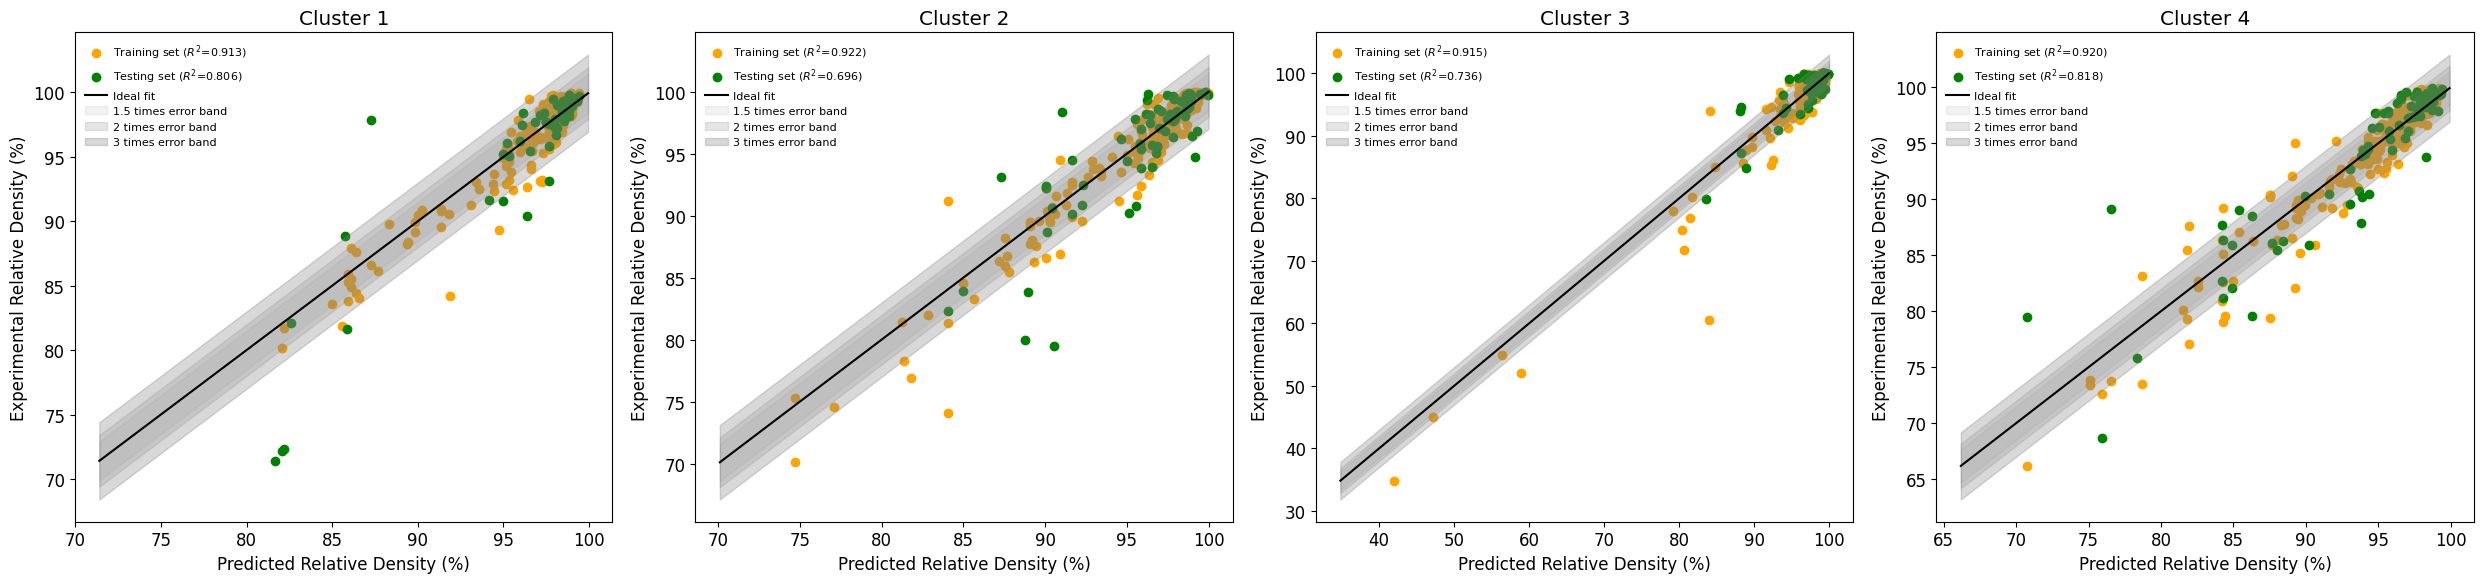

In [ ]:
file_name = '/content/drive/MyDrive/GOOGLE COLAB/Paper_Relative_Density/dataset.xlsx'
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2

def data_training_testing(df):
  X = df.iloc[:, :-1]
  y = df.iloc[:, -1]
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

fig, axs = plt.subplots(1, 4, figsize=(25, 6))
for i in range(1, 5):
  model_name = f'XGBRegressor_best_model_cluster_{i}.pkl'
  model_dir = os.path.join(output_folder, model_name)
  with open(model_dir, 'rb') as file:
    model = pickle.load(file)
  sheet_name = f'Cluster {i}'
  df = pd.read_excel(file_name, sheet_name=sheet_name)
  X_train, X_test, y_train, y_test = data_training_testing(df)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  train_mae, train_mse, train_r2 = calculate_metrics(y_train, y_train_pred)
  test_mae, test_mse, test_r2 = calculate_metrics(y_test, y_test_pred)
  print(f'Cluster {i} Metrics:')
  print(f'Training: MAE={train_mae:.4f}, MSE={train_mse:.4f}, R2={train_r2:.4f}')
  print(f'Testing: MAE={test_mae:.4f}, MSE={test_mse:.4f}, R2={test_r2:.4f}')
  print('--------------------------------------------')

  ax = axs[i-1]
  ax.scatter(y_train_pred, y_train, color='orange', label = f'Training set ($R^2$={train_r2:.3f})')
  ax.scatter(y_test_pred, y_test, color='green', label = f'Testing set ($R^2$={test_r2:.3f})')
  line = np.linspace(min(min(y_train), min(y_test)), max(max(y_train), max(y_test)), 100)
  ax.plot(line, line, color='black', linestyle='-', label='Ideal fit')
  ax.fill_between(line, line - 1.5, line + 1.5, color='gray', alpha=0.1, label='1.5 times error band')
  ax.fill_between(line, line - 2, line + 2, color='gray', alpha=0.2, label='2 times error band')
  ax.fill_between(line, line - 3, line + 3, color='gray', alpha=0.3, label='3 times error band')
  ax.legend(fontsize=8, frameon=False, loc='upper left', handlelength=2, handletextpad=0.5)
  ax.set_title(f'Cluster {i}')
  ax.set_ylabel('Experimental Relative Density (%)')
  ax.set_xlabel('Predicted Relative Density (%)')



plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/GOOGLE COLAB/Paper_Relative_Density/Images/RFRegressor_predicitions.svg', format='svg')
plt.show()